In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import binom

from inference.cmb_ps import CMBPS
from inference.utils import unnormalize_phi, normalize_phi, log_prior_phi, sample_prior_phi, log_likelihood_eps_phi, get_phi_bounds
from inference.hmc import HMC

In [2]:
device = 0
N = 500 # Number of sampled parameters
M = 4   # Number of MCMC chains per parameter

norm_phi_mode = 'compact' # Normalization mode for phi among ['compact', 'inf', None]
phi_min, phi_max = get_phi_bounds() # Bounds on phi (unnormalized)
phi_min, phi_max = phi_min.numpy(), phi_max.numpy()

nparams = len(phi_min) # Number of parameters

In [3]:
# Emulator of the CMB PS
ps_model = CMBPS(norm_input_phi=norm_phi_mode).to(device)

In [4]:
#
# Prior, likelihood, and posterior functions
#

sample_prior = lambda n: sample_prior_phi(n, norm=norm_phi_mode, device=device)
log_likelihood = lambda phi, x: log_likelihood_eps_phi(phi, x, ps_model)
log_prior = lambda phi: log_prior_phi(phi, norm=norm_phi_mode)

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

In [5]:
phi_min_norm, phi_max_norm = get_phi_bounds(device=device)
phi_min_norm, phi_max_norm = normalize_phi(phi_min_norm, mode=norm_phi_mode), normalize_phi(phi_max_norm, mode=norm_phi_mode)

def collision_manager(q, p, p_nxt):
    p_ret = p_nxt

    for i in range(nparams):
        crossed_min_boundary = q[..., i] < phi_min_norm[i]
        crossed_max_boundary = q[..., i] > phi_max_norm[i]

        # Reflecting boundary conditions
        p_ret[..., i][crossed_min_boundary] = -p[..., i][crossed_min_boundary]
        p_ret[..., i][crossed_max_boundary] = -p[..., i][crossed_max_boundary]

    return p_ret

In [6]:
# Generate test observations
phi_test = sample_prior(N)
ps_test = ps_model(phi_test)
x_test = torch.fft.ifft2(torch.fft.fft2(torch.randn((N, 256, 256), device=device))*torch.sqrt(ps_test)).real.unsqueeze(1)
x_test = x_test.repeat(1, M, 1, 1).reshape(M*N, 256, 256)

In [7]:
#
# Inference
#

burnin =  0
nsamples = 200
stepsize = 0.001
nleap = (5, 15) # Number of leapfrog steps per HMC iteration is sampled uniformly from this range
epsadapt = 100

log_prob = lambda phi: log_posterior(phi, x_test)
def log_prob_grad(phi):
    """ Compute the log posterior and its gradient."""
    phi.requires_grad_(True)
    log_prob = log_posterior(phi, x_test)
    grad_log_prob = torch.autograd.grad(log_prob, phi, grad_outputs=torch.ones_like(log_prob))[0]
    phi.requires_grad_(False)
    return log_prob.detach(), grad_log_prob
hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)
hmc.set_collision_fn(collision_manager)

phi_0 = sample_prior(M*N)
samples = hmc.sample(phi_0,
                     nsamples=nsamples,
                     burnin=burnin,
                     step_size=stepsize,
                     nleap=nleap,
                     epsadapt=epsadapt,
                     verbose=True)

Adapting step size using 100 iterations


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:06<00:00,  3.07s/it]


Step size fixed to :  tensor([0.0121, 0.0114, 0.0113,  ..., 0.0071, 0.0081, 0.0059], device='cuda:0')


100%|██████████| 200/200 [10:32<00:00,  3.16s/it]


In [8]:
# Unnormalize samples and reshape
samples = unnormalize_phi(samples, mode=norm_phi_mode).cpu().numpy()
samples = samples.reshape(N, M, nsamples, nparams)

# Unnormalize test parameters
phi_test = unnormalize_phi(phi_test, mode=norm_phi_mode).cpu().numpy()

In [9]:
# Compute ESS and Rhat
ess = np.zeros((N, nparams))
rhat = np.zeros((N, nparams))

for i in range(N):
    az_infdata = az.convert_to_inference_data(samples[i])
    ess[i] = az.ess(az_infdata)['x'].values
    rhat[i] = az.rhat(az_infdata)['x'].values

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


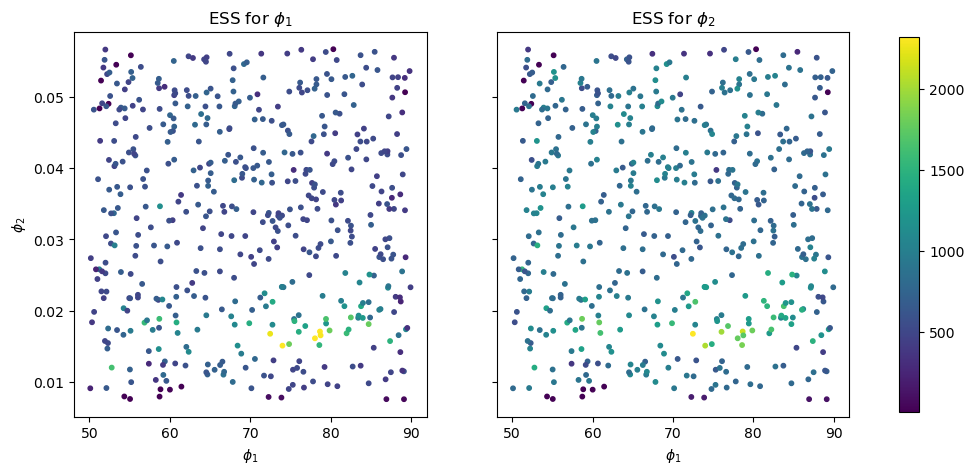

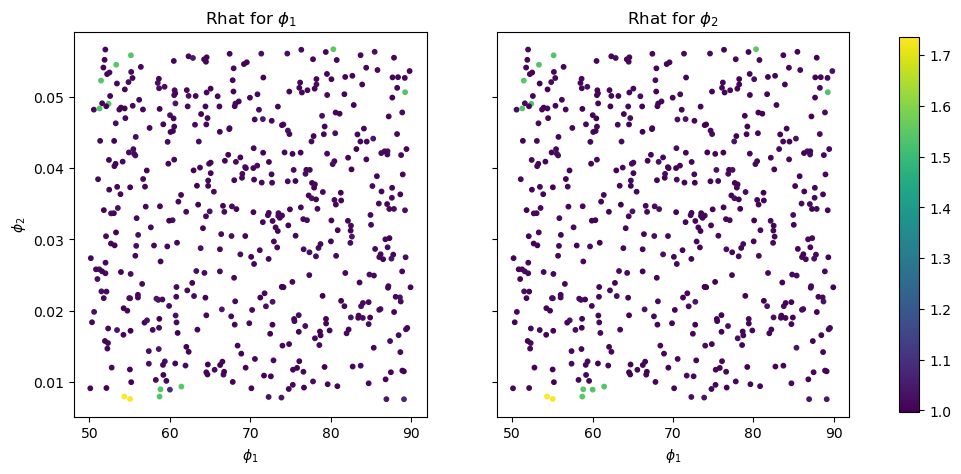

In [10]:
# Plot ESS in parameter space
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(phi_test[:, 0], phi_test[:, 1], c=ess[:, 0], s=10)
ax[0].set_xlabel(r'$\phi_1$')
ax[0].set_ylabel(r'$\phi_2$')
ax[0].set_title('ESS for $\phi_1$')
ax[1].scatter(phi_test[:, 0], phi_test[:, 1], c=ess[:, 1], s=10)
ax[1].set_xlabel(r'$\phi_1$')
ax[1].set_title('ESS for $\phi_2$')
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.12, 0.02, 0.75])
fig.colorbar(ax[0].collections[0], cax=cbar_ax)
plt.show()

# Plot Rhat in parameter space
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(phi_test[:, 0], phi_test[:, 1], c=rhat[:, 0], s=10)
ax[0].set_xlabel(r'$\phi_1$')
ax[0].set_ylabel(r'$\phi_2$')
ax[0].set_title('Rhat for $\phi_1$')
ax[1].scatter(phi_test[:, 0], phi_test[:, 1], c=rhat[:, 1], s=10)
ax[1].set_xlabel(r'$\phi_1$')
ax[1].set_title('Rhat for $\phi_2$')
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.12, 0.02, 0.75])
fig.colorbar(ax[0].collections[0], cax=cbar_ax)
plt.show()

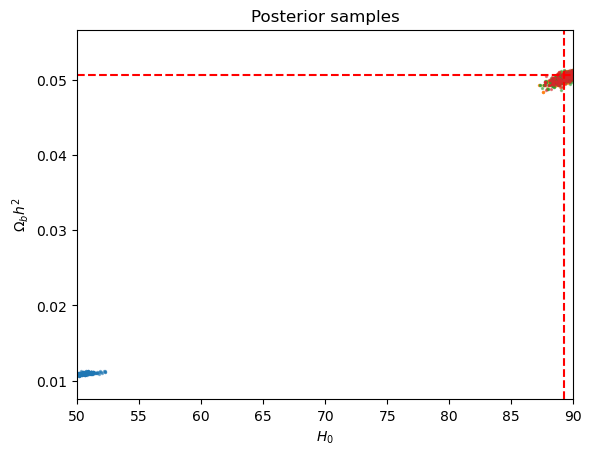

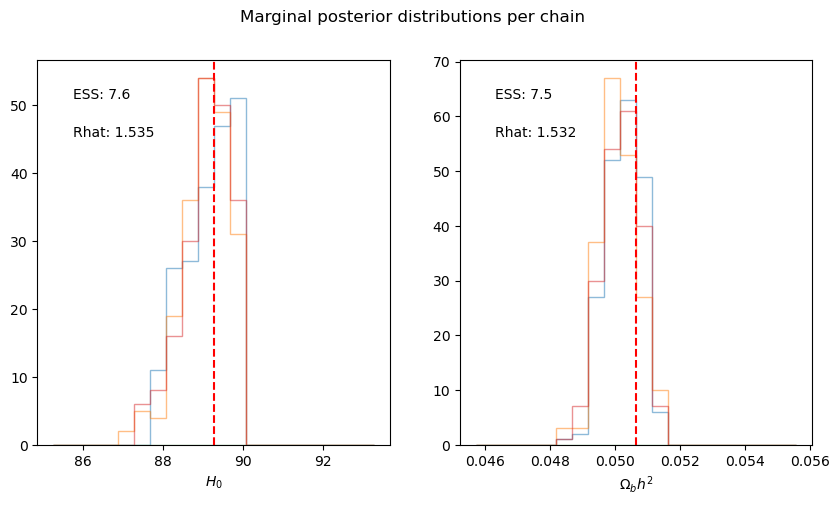

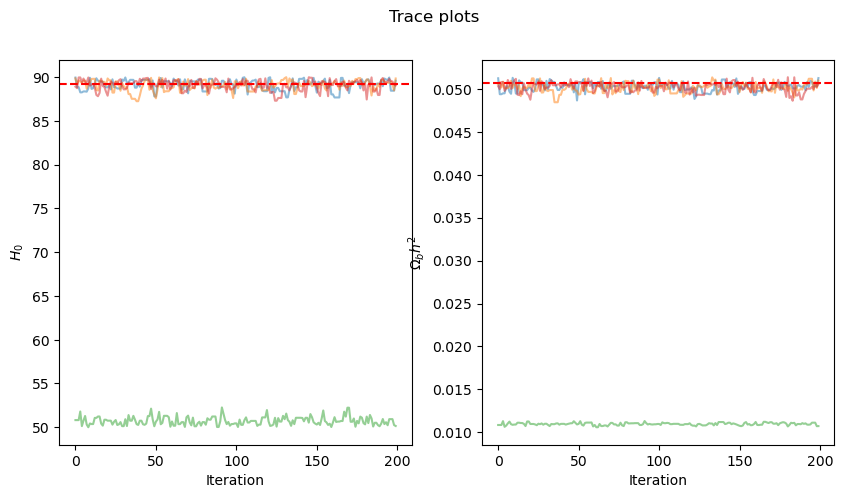

In [33]:
#
# Plot for a random phi_test / posterior estimation
#

i = np.random.randint(0, N)
bad_rhat_indices = np.where(rhat[:, 0] > 1.2)[0]
i = bad_rhat_indices[np.random.randint(0, len(bad_rhat_indices))]

plt.figure()
for j in range(M):
    plt.scatter(samples[i, j, :, 0], samples[i, j, :, 1], s=2, alpha=0.5)
plt.axvline(phi_test[i, 0], color='red', linestyle='--')
plt.axhline(phi_test[i, 1], color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(phi_min[0], phi_max[0])
plt.ylim(phi_min[1], phi_max[1])
plt.title("Posterior samples")
plt.show()

chains_id = np.random.choice(M, min(M, 5), replace=False)

dphi = phi_max - phi_min
ranges_min = phi_test[i] - 0.1*dphi
ranges_max = phi_test[i] + 0.1*dphi

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for j in chains_id:
    axs[0].hist(samples[i, j, :, 0], alpha=0.5, bins=20, range=(ranges_min[0].item(), ranges_max[0].item()), histtype='step')
    axs[1].hist(samples[i, j, :, 1], alpha=0.5, bins=20, range=(ranges_min[1].item(), ranges_max[1].item()), histtype='step')
axs[0].axvline(phi_test[i, 0], color='red', linestyle='--')
axs[1].axvline(phi_test[i, 1], color='red', linestyle='--')
axs[0].set_xlabel(r"$H_0$")
axs[1].set_xlabel(r"$\Omega_b h^2$")
for j in range(2):
    xmin, xmax = axs[j].get_xlim()
    ymin, ymax = axs[j].get_ylim()
    axs[j].text(xmin + 0.1*(xmax - xmin), ymax - 0.1*(ymax - ymin), "ESS: {:.1f}".format(ess[i, j]))
    axs[j].text(xmin + 0.1*(xmax - xmin), ymax - 0.2*(ymax - ymin), "Rhat: {:.3f}".format(rhat[i, j]))
plt.suptitle("Marginal posterior distributions per chain")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for j in chains_id:
    axs[0].plot(samples[i, j, :, 0], alpha=0.5)
    axs[1].plot(samples[i, j, :, 1], alpha=0.5)
axs[0].axhline(phi_test[i, 0], color='red', linestyle='--')
axs[1].axhline(phi_test[i, 1], color='red', linestyle='--')
axs[0].set_xlabel("Iteration")
axs[1].set_xlabel("Iteration")
axs[0].set_ylabel(r"$H_0$")
axs[1].set_ylabel(r"$\Omega_b h^2$")
plt.suptitle("Trace plots")
plt.show()

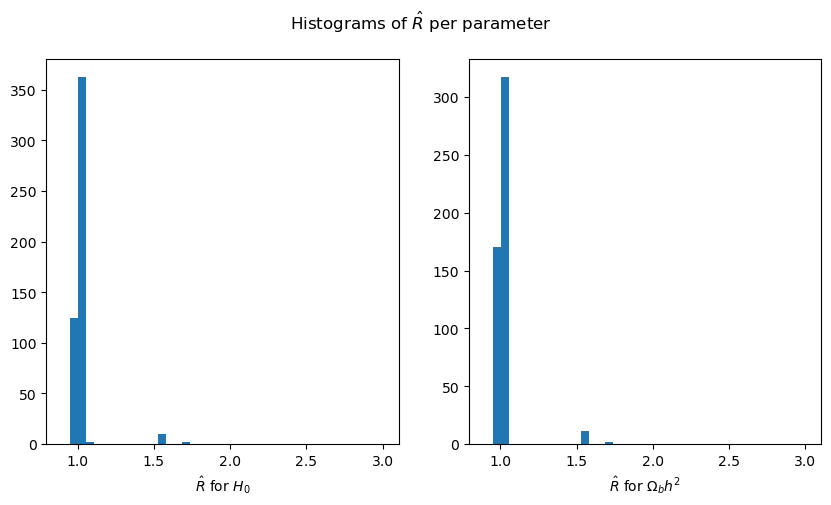

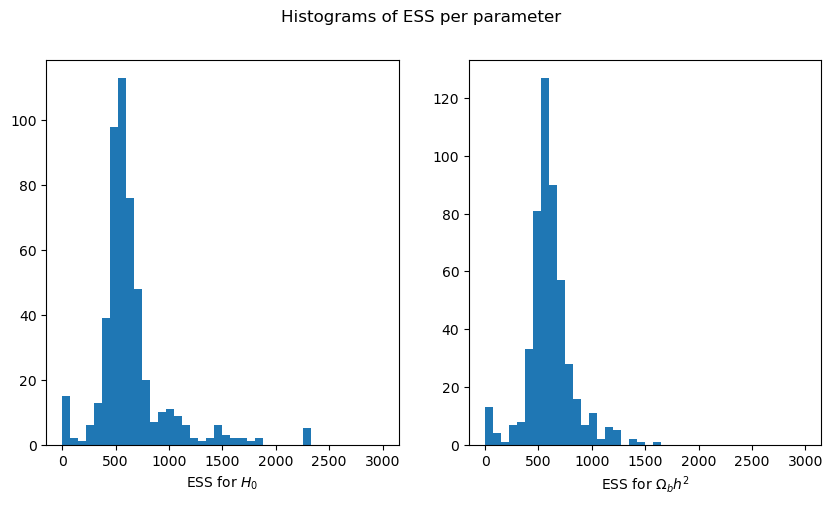

In [12]:
# Plot histograms of Rhat per parameter
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(rhat[:, 0], bins=40, range=(0.9, 3.0))
axs[1].hist(rhat[:, 1], bins=40, range=(0.9, 3.0))
axs[0].set_xlabel(r"$\hat{R}$ for $H_0$")
axs[1].set_xlabel(r"$\hat{R}$ for $\Omega_b h^2$")
plt.suptitle("Histograms of $\hat{R}$ per parameter")
plt.show()

# Plot histograms of ESS per parameter
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(ess[:, 0], bins=40, range=(0, 3000))
axs[1].hist(ess[:, 1], bins=40, range=(0, 3000))
axs[0].set_xlabel(r"ESS for $H_0$")
axs[1].set_xlabel(r"ESS for $\Omega_b h^2$")
plt.suptitle("Histograms of ESS per parameter")
plt.show()

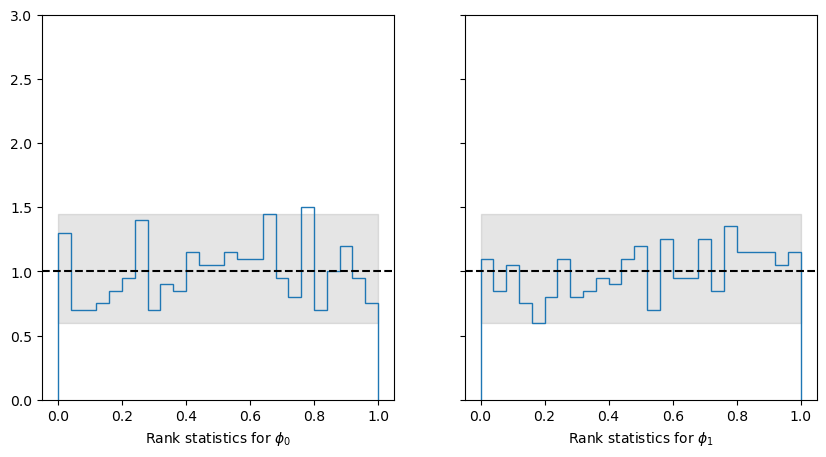

In [14]:
#
# Simulation-based calibration
#

# Compute rank statistics
ranks = np.zeros((N, nparams))
autocorr_length_per_chain = np.zeros((N, nparams))

for i in range(N):
    for j in range(nparams):
        autocorr_length_per_chain[i, j] = nsamples*M / ess[i, j]
        ranks[i, j] = np.mean((samples[i, :, ::max(int(autocorr_length_per_chain[i, j]), 1), j].flatten() < phi_test[i, j]).astype(float))

# Plot ranks statistics
nbins = 25
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(2):
    n, bins, _ = axs[i].hist(ranks[:, i], bins=nbins, density=True, histtype='step', range=(0, 1))
    bins_centers = (bins[:-1]+bins[1:])/2
    q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
    q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
    axs[i].axhline(1.0, color='black', linestyle='--')
    axs[i].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
    axs[i].set_xlabel(f"Rank statistics for $\phi_{i}$")
axs[0].set_ylim([0, 3])
plt.show()